> https://huggingface.co/nlpconnect/vit-gpt2-image-captioning

In [1]:
import os
imgs = os.listdir('./data/target_cleaned')

In [2]:
path = os.path.join('./data/target_cleaned' , imgs[0])


In [3]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [4]:
import matplotlib.pyplot as plt

max_length = 60
num_beams = 15
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}


def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")

        images.append(i_image)

        pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)

        output_ids = model.generate(pixel_values, **gen_kwargs)

        preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        preds = [pred.strip() for pred in preds]
        
        # Display the image
        #plt.imshow(i_image)
        #plt.title(preds[0])
        #plt.show()
        
    return preds , i_image


In [5]:
predict_step([path])

(['a man dressed as a pirate in a pirate costume'],
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=216x511 at 0x7EFD031548B0>)

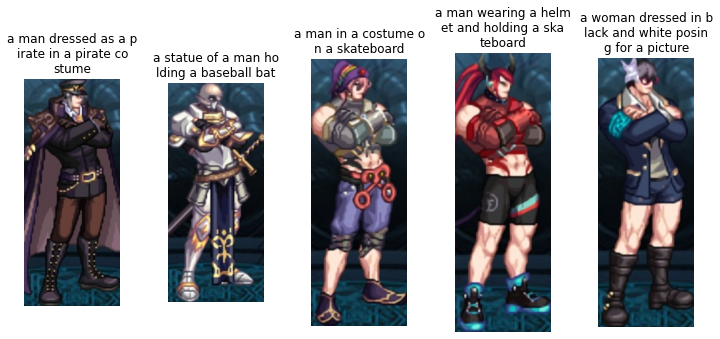

In [6]:
import matplotlib.pyplot as plt
import os

fig, axs = plt.subplots(1, 5, figsize=(12, 6))

json_list = []

for idx, img in enumerate(imgs[:5]):
    json = {}
    path = os.path.join('./data/target_cleaned', img)
    
    pred, img = predict_step([path])
    json["file_name"] = img
    json['text'] = pred[0]
    json_list.append(json)

    # Format the title with line breaks if it exceeds 20 characters
    title = pred[0]
    if len(title) > 20:
        title = '\n'.join([title[i:i+20] for i in range(0, len(title), 20)])
    
    # Display the image
    axs[idx].imshow(img)
    axs[idx].set_title(title)
    axs[idx].axis('off')

plt.subplots_adjust(wspace=0.5)

plt.show()


In [ ]:
json_list = []
for img in imgs:
    json = {}
    path = os.path.join('./data/target_cleaned' , img)
    try:
        pred = predict_step([path])
        json["file_name"] = img
        json['text'] = pred[0]
        json_list.append(json)
    except:
        print(path)
        

./data/target_cleaned/447.jpg


In [8]:
from tqdm import tqdm
json_list = []
for img in tqdm(imgs):
    json = {}
    path = os.path.join('./data/target_cleaned' , img)
    try:
        pred = predict_step([path])
        json["file_name"] = img
        json['text'] = pred[0]
        json_list.append(json)
    except:
        print(path)
        

100%|██████████| 425/425 [37:26<00:00,  5.29s/it]


In [12]:
import jsonlines

with jsonlines.open('metadata.jsonl', mode='w') as writer:
    for item in json_list:
        writer.write(item)
